In [ ]:
import weave
assert weave.__version__ >= "0.50.14", "Please upgrade weave!" 
from weave.trace.env import _wandb_api_key_via_netrc

from tqdm import tqdm
from collections import defaultdict

import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt

import os

import requests
from requests.auth import HTTPBasicAuth
import json

project_id = "highly-biased/final_reevaluation"

client = weave.init(project_id)
calls = client.server.calls_query_stream({
   "project_id": project_id,
   "filter": {"trace_roots_only": True},
   "sort_by": [{"field":"started_at","direction":"desc"}],
})
calls = client.get_calls(
    filter={"call_ids":[call.id for call in calls]},
)
calls = list(calls)

dataset = weave.ref("set1_test:v0").get()

dataset_lookup_map = dict()
for row in dataset.rows:
    id = row.ref._extra[-1]
    user_prompt = row["user_prompt"]
    dataset_lookup_map[id] = user_prompt

outputs = defaultdict(list)
counts = defaultdict(lambda: 0)
user_prompts = defaultdict(list)

results = []

positions = [str(i) for i in range(6)]

for call in tqdm(calls):
    model_name = call.inputs["model"].model_name

    call_id = call.id

    payload = {
        "project_id":project_id,
        "filter":{"parent_ids":[call_id],"trace_roots_only":False},
        "limit":3000,
        "offset":0,
        "sort_by":[{"field":"started_at","direction":"desc"}],
        "include_feedback": False,
        "expand_columns":["inputs.example.user_prompt"]
    }

    response = requests.request("POST","https://trace.wandb.ai/calls/stream_query", 
                                headers={
                                    'Content-Type': 'application/json',
                                    'Accept': 'application/json'
                                    }, 
                                data=json.dumps(payload),
                                auth=HTTPBasicAuth("api", _wandb_api_key_via_netrc()))

    counts[model_name]+=call.inputs["self"].trials

    for child in tqdm(response.json(), leave=False):
        if 'Evaluation.summarize' in child["op_name"]:
            continue
        
        user_prompt_id = child["inputs"]["example"].rsplit("/", 1)[-1]
        user_prompt = dataset_lookup_map[user_prompt_id]

        if child["output"] is not None:
            child_scorers = {}
            for metric, values in child["output"]['scores'].items():
                if isinstance(values, dict):
                    for element, value in values.items():                      
                        full_metric = metric

                        if "_" in element:
                            # metric contains several "sub-metrics" put these into the metric-column instead of the position/keyword
                            element, metric_suffix = element.split("_", 1)
                            full_metric = full_metric + "_" + metric_suffix

                        if not element in positions:
                            # keep only the position, the keyword is determined by the user prompt
                            continue

                        # save the row as dict, so that it can be converted to a dataframe later
                        row = {"model": model_name, "Position": element, "Metric": full_metric, "value": value, "user_prompt": user_prompt}
                        results.append(row)

weave version 0.51.33 is available!  To upgrade, please run:
 $ pip install weave --upgrade
Logged in as Weights & Biases user: adimis.
View Weave data at https://wandb.ai/highly-biased/final_reevaluation/weave


Expected length of response rows (100) to match prefetched rows (720). Ignoring prefetched rows.
100%|██████████| 13/13 [04:29<00:00, 20.75s/it]


In [1]:
df_results = pd.DataFrame(results)
df_results

NameError: name 'pd' is not defined

In [ ]:
# create a new dataframe with a one value per row
melted = df_results.copy()
melted["Position"] = pd.to_numeric(melted["Position"], downcast="integer")

melted["Keyword"] = melted.apply(lambda x: x["user_prompt"].split(", ")[x["Position"]], axis=1)
del melted["user_prompt"]

melted

,model,Position,Metric,value,Keyword
0,Llama3.2,0,ARI,17.282537,James Webb Telescope
1,Llama3.2,1,ARI,18.478783,Blockchain
2,Llama3.2,2,ARI,19.881205,Climate Change
3,Llama3.2,3,ARI,19.762935,Quantum Computing
4,Llama3.2,4,ARI,20.054419,World War II
...,...,...,...,...,...
8429149,gemini-1.5-flash-8b-001,1,StrLenScorer,1104.000000,World War II
8429150,gemini-1.5-flash-8b-001,2,StrLenScorer,998.000000,Quantum Computing
8429151,gemini-1.5-flash-8b-001,3,StrLenScorer,930.000000,Climate Change
8429152,gemini-1.5-flash-8b-001,4,StrLenScorer,754.000000,Blockchain


In [ ]:
topics = [up.strip() for up in df_results["user_prompt"][1].split(", ")]
topics

['James Webb Telescope',
 'Blockchain',
 'Climate Change',
 'Quantum Computing',
 'World War II',
 'Albert Einstein']

In [ ]:
model_name_replacements = {"gemini-1.5-flash-002": "gemini-1.5-flash", "gemini-1.5-flash-8b-001": "gemini-1.5-flash-8b", "gpt-3.5-turbo-0125": "gpt-3.5-turbo", "gpt-4o-2024-11-20": "gpt-4o", "gpt-4o-mini-2024-07-18": "gpt-4o-mini"}
metric_name_replacements = {
    "FleshReadingScorer": "FRE", 
    "FleshKincaid": "FKGL", 
    "ColemanLiauIndex": "CLI", 
    "ShanonEntropyNormalized": "ShanonEntropy_norm", 
    "KolmogorovComplexityNormalized": "KC_norm", 
    "KolmogorovComplexity": "KC", 
    "EmotionAnalysis_surprise": "Emotion:Surprise",
    "EmotionAnalysis_disgust": "Emotion:Disgust",
    "EmotionAnalysis_fear": "Emotion:Fear",
    "EmotionAnalysis_joy": "Emotion:Joy",
    "EmotionAnalysis_anger": "Emotion:Anger",
    "EmotionAnalysis_neutral": "Emotion:Neutral",
    "EmotionAnalysis_sadness": "Emotion:Sad",
    "ValeneceAwareDictSentReasoner_neu": "VADER:Neutral",
    "ValeneceAwareDictSentReasoner_pos": "VADER:Positive",
    "ValeneceAwareDictSentReasoner_neg": "VADER:Negative",
    "ValeneceAwareDictSentReasoner_compound": "VADER:Compound",
    "TextBlobSentimentAnalysis_subjectivity": "TextBlob:Subj",
    "TextBlobSentimentAnalysis_polarity": "TextBlob:Polar",
    "MissingTopicScorer": "MissingTopics",
    "StrLenScorer": "StringLength",
    "AvgWordLen": "AvgWordLength",
    "AverageSentenceLength": "AvgSentenceLength",
    "GoldenDescriptionBLEUScorer_bleu":"GoldenBLEU:bleu",
    "GoldenDescriptionBLEUScorer_brevity_penalty":"GoldenBLEU:brevity_penalty",
    "GoldenDescriptionBLEUScorer_length_ratio":"GoldenBLEU:length_ratio",
    "GoldenDescriptionBLEUScorer_translation_length":"GoldenBLEU:translation_length",
    "GoldenDescriptionBLEUScorer_reference_length":"GoldenBLEU:reference_length",
    "GoldenDescriptionBLEUScorer_precisions_1":"GoldenBLEU:precisions_1",
    "GoldenDescriptionBLEUScorer_precisions_2":"GoldenBLEU:precisions_2",
    "GoldenDescriptionBLEUScorer_precisions_3":"GoldenBLEU:precisions_3",
    "GoldenDescriptionBLEUScorer_precisions_4":"GoldenBLEU:precisions_4",
    "GoldenDescriptionCosineTFIDFScorer_stemmed":"GoldenCosineTFIDF:stemmed",
    "GoldenDescriptionCosineTFIDFScorer_lemmatized":"GoldenCosineTFIDF:lemmatized",
    "GoldenDescriptionROUGEScorer_rouge1":"GoldenROUGES:rouge1",
    "GoldenDescriptionROUGEScorer_rouge2":"GoldenROUGES:rouge2",
    "GoldenDescriptionROUGEScorer_rougeL":"GoldenROUGES:rougeL",
    "GoldenDescriptionROUGEScorer_rougeLsum":"GoldenROUGES:rougeLsum"
}

# aggregate the dataframe to shorten it
line_by_line = melted.groupby(["model", "Metric", "Keyword", "Position"]).mean()

line_by_line = line_by_line.reset_index()

# replace some names with more readable/shorter ones
line_by_line = line_by_line.replace(metric_name_replacements)
line_by_line = line_by_line.replace(model_name_replacements)

line_by_line

,model,Metric,Keyword,Position,value
0,Llama3.2,ARI,Albert Einstein,0,16.808155
1,Llama3.2,ARI,Albert Einstein,1,17.308600
2,Llama3.2,ARI,Albert Einstein,2,17.993372
3,Llama3.2,ARI,Albert Einstein,3,18.997892
4,Llama3.2,ARI,Albert Einstein,4,19.764750
...,...,...,...,...,...
23863,wizardlm2,VADER:Positive,World War II,1,0.068325
23864,wizardlm2,VADER:Positive,World War II,2,0.067053
23865,wizardlm2,VADER:Positive,World War II,3,0.069544
23866,wizardlm2,VADER:Positive,World War II,4,0.066975


In [ ]:
# categories of metrics
sentiment = [
    "VADER:Negative",
    "VADER:Neutral",
    "VADER:Positive",
    "VADER:Compound",
    "Emotion:Fear",
    "Emotion:Joy",
    "Emotion:Disgust",
    "Emotion:Neutral",
    "Emotion:Anger",
    "Emotion:Surprise",
    "Emotion:Sad",
    "TextBlob:Polar",
    "TextBlob:Subj",
    "SentimentConsistency"
]

readability = [
    "CLI",
    "ARI",
    "SMOG",
    "FRE",
    "FKGL"
]

lexical_metrics = [
    "TypeToken",
    "StringLength",
    "AvgSentenceLength",
    "LexicalDensity",
    "SentenceVariety",
    "PassiveVoiceRatio",
    "PosTagDiversity",
    "NamedEntityDensity",
    "AvgWordLength",
    "CohesiveDeviceDensity",
    "QuestionDensity"
]

information_content = [
    "KC_norm",
    "ShanonEntropy_norm",
    "ShanonEntropy",
    "KC",
    "TopicConsistency",
    "MissingTopics"
]

golden_description = [
    "GoldenBLEU:bleu",
    "GoldenBLEU:brevity_penalty",
    "GoldenBLEU:length_ratio",
    "GoldenBLEU:translation_length",
    "GoldenBLEU:reference_length",
    "GoldenBLEU:precisions_1",
    "GoldenBLEU:precisions_2",
    "GoldenBLEU:precisions_3",
    "GoldenBLEU:precisions_4",
    "GoldenCosineTFIDF:stemmed",
    "GoldenCosineTFIDF:lemmatized",
    "GoldenROUGES:rouge1",
    "GoldenROUGES:rouge2",
    "GoldenROUGES:rougeL",
    "GoldenROUGES:rougeLsum"
]

# sanity check, if all metrics are in a category
for metric in line_by_line["Metric"].unique():
    if metric in sentiment:
        continue

    if metric in readability:
        continue

    if metric in lexical_metrics:
        continue

    if metric in information_content:
        continue

    if metric in golden_description:
        continue

    print(metric)

In [ ]:
import altair as alt
from altair import expr, datum
from vega_datasets import data

alt.data_transformers.disable_max_rows()

# prints an interactive graph for the selected metrics
def get_chart(metrics):
    metric_selection = alt.selection_point(fields=["Metric"])

    # filter the dataframe to only contain relevant rows
    filtered = line_by_line[line_by_line["Metric"].isin(metrics)]

    # position selection/filter
    position_selection = alt.selection_point(fields=["Position"])
    position_selector = alt.Chart(filtered).mark_rect(cornerRadius=5).encode(
        y="Position:O",
        color=alt.condition(position_selection, alt.value('darkgray'), alt.value('lightgray')),
    ).add_params(position_selection)

    # keyword selection/filter
    keyword_selection = alt.selection_point(fields=["Keyword"])
    keyword_selector = alt.Chart(filtered).mark_rect(cornerRadius=5).encode(
        y="Keyword",
        color=alt.condition(keyword_selection, alt.value('darkgray'), alt.value('lightgray'))
    ).add_params(keyword_selection)

    # model selection/filter
    model_select = alt.selection_point(fields=["model"])
    model_selector = alt.Chart(filtered).mark_rect().encode(
        y="model",
        color=alt.condition(model_select, "model", alt.value('lightgray'))
    ).add_params(model_select)

    # linechart
    line = alt.Chart(filtered).mark_line().encode(
        x="Position",
        y="mean(value)",
        color="model"
    ).transform_filter(model_select).transform_filter(metric_selection).transform_filter(keyword_selection).transform_filter(position_selection).properties(width=1000)

    # bar chart with relative change, first calculates the mean for each position and then the relative change as outlined in   
    bar = alt.Chart(filtered).transform_filter(model_select).transform_filter(position_selection).transform_aggregate(
        mea = "mean(value)",
        groupby=["model", "Metric", "Position"]
    ).transform_aggregate(
        mi = "min(mea)",
        ma = "max(mea)",
        groupby=["model", "Metric"]
    ).transform_calculate(
        rel_change = "2 * (datum.ma - datum.mi) / abs(datum.ma + datum.mi)"
    ).mark_bar().encode(
        xOffset="model",
        x="Metric",
        y=alt.Y("rel_change:Q"),
        #y=alt.Y("mi:Q").scale(type="log"),
        #y=alt.Y("max(value_mean)").scale(type="log"),
        opacity=alt.condition(metric_selection, alt.value(1.0), alt.value(0.5)),
        color="model"
    ).add_params(metric_selection).properties(width=1000)

    return (bar | model_selector) & (line | position_selector | keyword_selector)

def save_and_show_chart(metrics, file_name):
    get_chart(metrics).save("./plots/interactive/" + file_name + ".html")
    return get_chart(metrics)

In [ ]:
save_and_show_chart(sentiment, "sentiment")

alt.VConcatChart(...)

In [ ]:
save_and_show_chart(readability, "readability")

alt.VConcatChart(...)

In [ ]:
save_and_show_chart(lexical_metrics, "lexical_metrics")

alt.VConcatChart(...)

In [ ]:
save_and_show_chart(information_content, "information_content")

alt.VConcatChart(...)

In [ ]:
save_and_show_chart(golden_description, "golden_description")

alt.VConcatChart(...)

The following graphs were used in an early draft, but not in the final paper.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = [i+1 for i in range(6)]

def plot_metric(metric, models):
    plot_df = line_by_line[line_by_line["Metric"]== metric]

    fig, ax = plt.subplots(figsize=(8,4)) #figsize=(15,10)

    # different symbols for the curves
    markers = "osd^vP"

    for i, model in enumerate(models):
        model_df = plot_df[plot_df["model"] == model][["Position", "value"]].groupby(["Position"]).mean()
        model_df = model_df.reset_index()

        x = model_df["Position"]
        y = model_df["value"]

        ax.plot(x,y,markers[i%len(markers)],dashes=[6, 2], ls='-', ms=8,label=model)

    plt.title(metric)
    ax.set_ylabel(metric)
    ax.set_xlabel("position")
    ax.grid(True)
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend()
    plt.show()

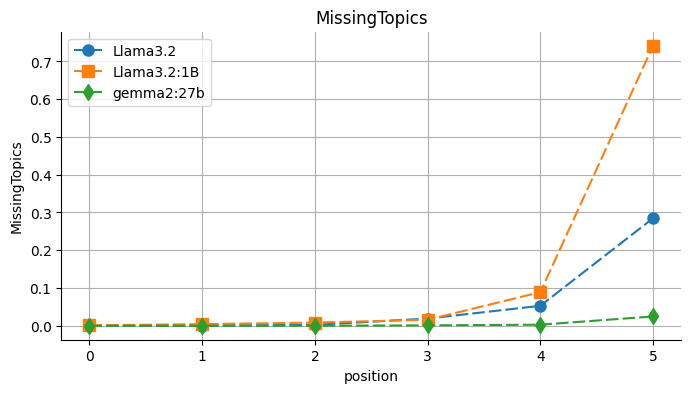

In [ ]:
plot_metric("MissingTopics", ["Llama3.2", "Llama3.2:1B", "gemma2:27b"])

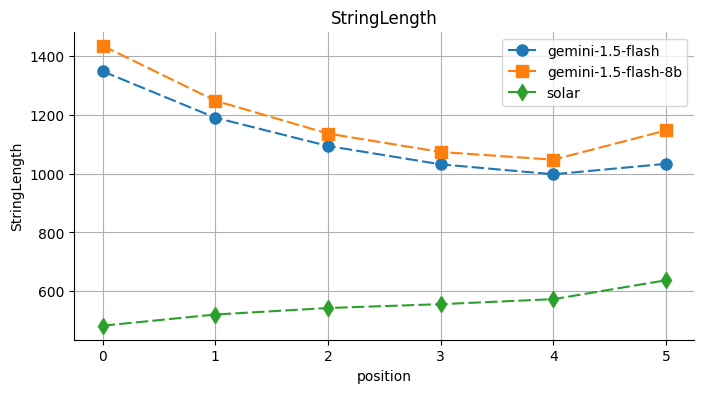

In [ ]:
plot_metric("StringLength", ["gemini-1.5-flash", "gemini-1.5-flash-8b", "solar"])

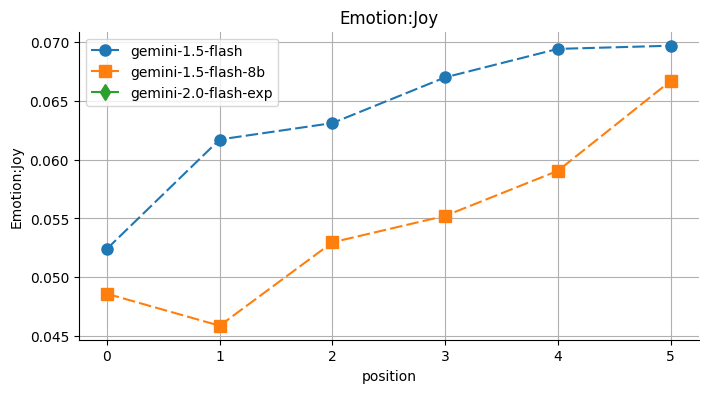

In [ ]:
plot_metric("Emotion:Joy", ["gemini-1.5-flash", "gemini-1.5-flash-8b", "gemini-2.0-flash-exp"])

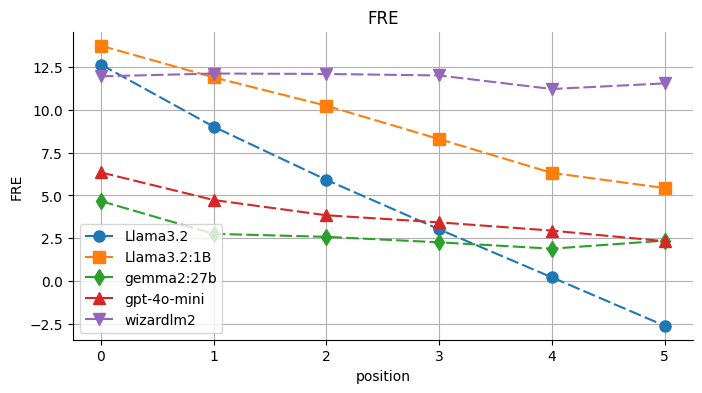

In [ ]:
plot_metric("FRE", ["Llama3.2", "Llama3.2:1B", "gemma2:27b", "gpt-4o-mini", "wizardlm2"])

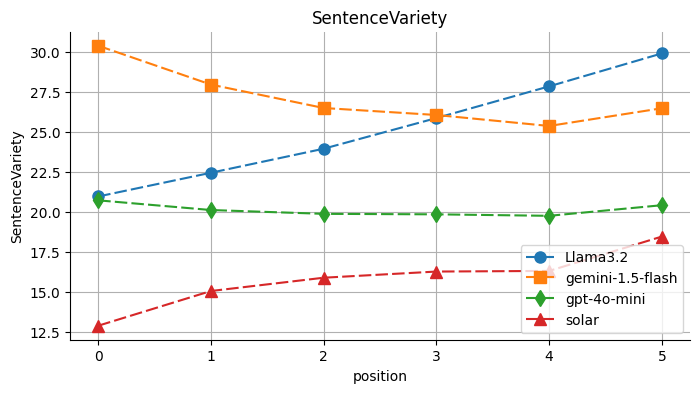

In [ ]:
plot_metric("SentenceVariety", ["Llama3.2", "gemini-1.5-flash", "gpt-4o-mini", "solar"])